In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import glob
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader

In [2]:
data_path = "/kaggle/input/nih-chest-x-ray-14-224x224-resized/images-224/images-224"  # adjust if needed
# Define transform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # make sure it's 1-channel
    transforms.Resize((128, 128)),  # resize smaller for faster training
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 2) - 1)  # scale to [-1, 1]
])

# Custom dataset loader
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, transform=None, limit=None):
        self.files = glob.glob(os.path.join(root_dir, "*.png"))
        if limit:  # optional: limit dataset size
            self.files = self.files[:limit]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            image = self.transform(image)
        return image, 0  # dummy label

# Example usage
trainset = ChestXrayDataset(data_path, transform=transform, limit=10000)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

# Check batch
images, _ = next(iter(trainloader))
print(images.shape)  # e.g. torch.Size([32, 1, 128, 128])

torch.Size([32, 1, 128, 128])


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
T = 300  # number of diffusion steps
# beta = torch.linspace(1e-4, 0.02, T).to(device)  # noise schedule
def cosine_Schedule(T,s=8e-3):
    def f(t):
        return torch.cos(((t / T + s) / (1 + s))*torch.pi*0.5)**2
    x = torch.linspace(0, T, T+1)
    alphas_cumprod = f(x) / f(torch.tensor([0]))
    beta = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
    beta = torch.clip(beta, 0.0001, 0.999) # Clip to avoid NaNs
    return beta.float()

beta = cosine_Schedule(T).to(device)
alpha = (1. - beta).to(device)
alpha_hat = (torch.cumprod(alpha, dim=0)).to(device)

def forward_diffusion_sample(x0, t):
    """Add noise to image x0 at timestep t"""
    noise = torch.randn_like(x0)

    # Get ᾱ_t for each image in the batch
    sqrt_alpha_hat = alpha_hat[t].view(-1, 1, 1, 1) ** 0.5
    sqrt_one_minus_alpha_hat = (1 - alpha_hat[t]).view(-1, 1, 1, 1) ** 0.5

    return sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise, noise

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__() #inherits the nn.module(required)
        self.net = nn.Sequential( 
            #in_che = grayscare(MNIST) = 1, RGB = 3, out_ch = number of filters/kernels to learn
            # kernel_size = size of filter, stride = step size wile sliding kernel
            nn.Conv2d(in_ch, out_ch, kernel_size = 3, padding=1), nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size = 3, padding=1), nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__() #inherits the nn.module
        self.down1 = DoubleConv(1, 64) #inp_ch , out_ch, shape = (batch, 32, 28, 28)
        self.pool1 = nn.MaxPool2d(2) #halfes the shape (batch, 32, 14, 14)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256) 
        self.pool3 = nn.MaxPool2d(2)
        # inp_ch , out_ch, kernel_size , stride
        self.bottleneck = DoubleConv(256, 512)

        # Upsampling path
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        # Final output layer
        self.final = nn.Conv2d(64, 1, 1)
        
    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        d3 = self.down3(p2)
        p3 = self.pool3(d3)

        b = self.bottleneck(p3)

        u3 = self.up3(b)
        # list of parameters to concat 
        # dim = the dimension along which to concat(here channel dimension = 1)
        # torch.cat = makes a single tensor by concatenating a sequence of tensors(batch, 128, H, W) 
        c3 = self.conv3(torch.cat([u3, d3], dim=1))
        u2 = self.up2(c3)
        c2 = self.conv2(torch.cat([u2, d2], dim=1))
        u1 = self.up1(c2)
        c1 = self.conv1(torch.cat([u1, d1], dim=1))

        return self.final(c1)

model = UNet().to(device)

# -----------------------------
# 4. Training loop
# -----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20
start_epoch = 0
# --- Try to resume from latest checkpoint ---
ckpts = sorted(glob.glob("/kaggle/working/checkpoint_epoch*.pth"))
if ckpts:
    latest_ckpt = ckpts[-1]
    checkpoint = torch.load(latest_ckpt, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"✅ Resumed from {latest_ckpt}, starting at epoch {start_epoch+1}")
else:
    print("🚀 No checkpoint found, starting fresh.")
for epoch in range(start_epoch, start_epoch + epochs):
    for images, _ in trainloader:
        images = images.to(device)

        t = torch.randint(0, T, (images.size(0),), device=device)
        noised, noise = forward_diffusion_sample(images, t)

        pred_noise = model(noised)
        loss = F.mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
        }, f"/kaggle/working/checkpoint_epoch{epoch+1}.pth")
        print(f"💾 Saved checkpoint at epoch {epoch+1}")


# -----------------------------
# 5. Sampling (reverse process)
# -----------------------------
@torch.no_grad()
def sample(model, n=5,image_size=128):
    model.eval()
    x = torch.randn(n, 1, image_size, image_size).to(device)  # start from pure noise
    
    for t in range(T-1, -1, -1):
        z = torch.randn_like(x) if t > 0 else 0
        pred_noise = model(x)
        alpha_t = alpha[t]
        alpha_hat_t = alpha_hat[t]
        beta_t = beta[t]

        x = (1/torch.sqrt(alpha_t)) * (x - ((1-alpha_t)/torch.sqrt(1-alpha_hat_t)) * pred_noise) + torch.sqrt(beta_t) * z
    return x

samples = sample(model, n=8).cpu()

Using device: cuda
🚀 No checkpoint found, starting fresh.
Epoch 1 | Loss: 0.0775
Epoch 2 | Loss: 0.0617
Epoch 3 | Loss: 0.0984
Epoch 4 | Loss: 0.0426
Epoch 5 | Loss: 0.0486
💾 Saved checkpoint at epoch 5
Epoch 6 | Loss: 0.0394
Epoch 7 | Loss: 0.0455
Epoch 8 | Loss: 0.0237
Epoch 9 | Loss: 0.0415
Epoch 10 | Loss: 0.0221
💾 Saved checkpoint at epoch 10
Epoch 11 | Loss: 0.0319
Epoch 12 | Loss: 0.0324
Epoch 13 | Loss: 0.0451
Epoch 14 | Loss: 0.0170
Epoch 15 | Loss: 0.0206
💾 Saved checkpoint at epoch 15
Epoch 16 | Loss: 0.0256
Epoch 17 | Loss: 0.0330
Epoch 18 | Loss: 0.0351
Epoch 19 | Loss: 0.0234
Epoch 20 | Loss: 0.0572
💾 Saved checkpoint at epoch 20


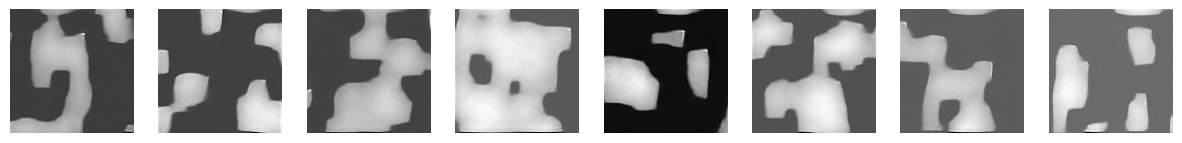

In [11]:
fig, axs = plt.subplots(1, 8, figsize=(15,2))
for i in range(8):
    axs[i].imshow((samples[i,0]+1)/2, cmap="gray")  # back to [0,1]
    axs[i].axis("off")
plt.show()